In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils



import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
epochs = 20
batch_size = 64

## Loading data

In [3]:
train_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_train.csv'
test_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_valid.csv'
train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
print(train_data['label'].value_counts())

16    1294
15    1279
10    1241
21    1225
5     1204
17    1199
3     1196
13    1196
18    1186
22    1164
8     1162
19    1161
12    1151
2     1144
0     1126
23    1118
9     1114
6     1090
14    1088
20    1082
11    1055
7     1013
1     1010
4      957
Name: label, dtype: int64


In [6]:
print(test_data['label'].value_counts())

4     498
7     436
1     432
11    394
6     348
14    347
20    346
23    332
0     331
9     331
2     310
12    291
8     288
22    267
19    266
18    248
5     247
13    246
17    246
3     245
10    209
21    206
15    164
16    144
Name: label, dtype: int64


In [7]:
n_classes = len(set(list(train_data['label'])+list(test_data['label'])))
print('number of classes: ', n_classes)

number of classes:  24


## Preparing data

### Spliting data

In [8]:
_y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

_X_train = train_data.values.reshape(-1,1,28,28)
X_test = test_data.values.reshape(-1,1,28,28)


In [9]:
_X_train[0].shape
_y_train[0].shape

()

In [10]:
# Spliting the training data into two sets for training and validation
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}. y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}. y_test shape: {y_test.shape}')

X_train shape: (21964, 1, 28, 28). y_train shape: (21964,)
X_val shape: (5491, 1, 28, 28). y_val shape: (5491,)
X_test shape: (7172, 1, 28, 28). y_test shape: (7172,)


### Showing some image and label examples

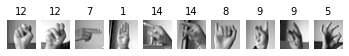

In [11]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[15:25], y_train[15:25])

### Normalize the data


In [12]:
# Exploring min and max values of image pixels
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')

X_train: min= 0, max=255


In [13]:
# Normalize images by dividing pixel values by the max
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

print(f'X_train: min= {X_train.min()}, max={X_train.max()}')
print(f'X_val: min= {X_val.min()}, max={X_val.max()}')
print(f'X_test: min= {X_test.min()}, max={X_test.max()}')

X_train: min= 0.0, max=1.0
X_val: min= 0.0, max=1.0
X_test: min= 0.0, max=1.0


In [14]:
# Exploring the class labels to consider encoding them if neccessary
n_classes

24

In [15]:
type(y_train)

pandas.core.series.Series

### Loading data to Dataset and Dataloader object

In [16]:
class CustomDataset():
    def __init__(self, X, Y) -> None:
        super().__init__()
        self.X = X
        self.Y = Y.tolist()
        # print(type(self.X), type(self.Y))


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        self.x_tensor = torch.tensor(x, dtype = torch.float) #float32
        self.y_tensor = torch.tensor(y, dtype = torch.int64)
        return self.x_tensor, self.y_tensor

# passing data to the customized dataset class we created
train_datatensor = CustomDataset(X_train, y_train)
val_datatensor = CustomDataset(X_val, y_val)
test_datatensor = CustomDataset(X_test, y_test)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )
test_dataloader = DataLoader(test_datatensor, sampler = torch.utils.data.SequentialSampler(test_datatensor), batch_size=batch_size )



In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


## Creating model

In [23]:
class Net(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.softmax(self.fc3(x))
        return self.softmax(x)

model= Net(n_classes = n_classes)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


In [19]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

## Training model

In [24]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total = 0
    correct = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            # print('labels.size(0)', labels.size(0))
            total+= 1 #labels.size(0)
            correct+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct / total, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './asl.pth'
    if val_loss < best_loss:
        torch.save(model.state_dict(), checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




100%|██████████| 172/172 [00:00<00:00, 498.38it/s]


Epoch 1/20: Train loss = 3.1780653381625292, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 554.98it/s]


Epoch 2/20: Train loss = 3.178064925528336, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 282.77it/s]


Epoch 3/20: Train loss = 3.178065504743196, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 356.93it/s]


Epoch 4/20: Train loss = 3.1780646152718446, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 336.91it/s]


Epoch 5/20: Train loss = 3.178064832520797, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 334.01it/s]


Epoch 6/20: Train loss = 3.1780647679707887, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 335.82it/s]


Epoch 7/20: Train loss = 3.178065361067371, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 296.67it/s]


Epoch 8/20: Train loss = 3.178064999101464, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 347.00it/s]


Epoch 9/20: Train loss = 3.1780654523396943, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 350.76it/s]


Epoch 10/20: Train loss = 3.1780650782272803, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 312.92it/s]


Epoch 11/20: Train loss = 3.1780651792168095, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 354.24it/s]


Epoch 12/20: Train loss = 3.1780648592431127, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 364.54it/s]


Epoch 13/20: Train loss = 3.1780654551160388, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 366.07it/s]


Epoch 14/20: Train loss = 3.1780657664136593, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 389.13it/s]


Epoch 15/20: Train loss = 3.178065432211197, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 309.45it/s]


Epoch 16/20: Train loss = 3.17806440461671, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 350.20it/s]


Epoch 17/20: Train loss = 3.178065350309036, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 391.63it/s]


Epoch 18/20: Train loss = 3.178065312828386, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 395.34it/s]


Epoch 19/20: Train loss = 3.1780644774957514, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


100%|██████████| 172/172 [00:00<00:00, 331.90it/s]

Epoch 20/20: Train loss = 3.1780645781382377, Validation loss = 3.178079186483871, Validation accuracy: 0.0371


## Testing model

In [25]:
model.load_state_dict(best_model_wts)
_, test_accuracy, test_preds = eval_fn(test_dataloader, model)
print(f'Model performance on test set: Accuracy = {test_accuracy}')

100%|██████████| 225/225 [00:00<00:00, 392.09it/s]

Model performance on test set: Accuracy = 0.07027777777777777
